### G2. Augmentation

- 목표
    - Augmentation을 모델 학습에 적용하기
    - Augmentation의 적용을 통한 학습 효과 확인하기
    - 최신 data augmentation 기법 구현 및 활용하기

In [75]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

#### 1. 데이터셋 만들기

In [76]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


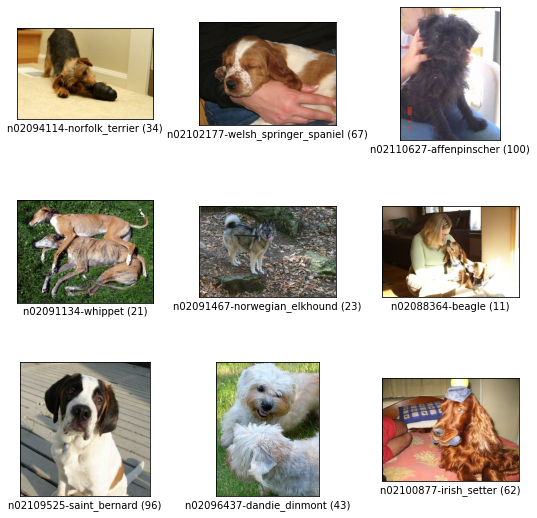

In [77]:
fig = tfds.show_examples(ds_info, ds_train)

In [78]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32)/255., label

##### 1-1 기본 Augmentation

In [79]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [80]:
def get_clip_box(image_a, image_b, img_size=224):
    
    x = tf.cast(tf.random.uniform([], 0, img_size), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, img_size), tf.int32)
    
    _prob = tf.random.uniform([], 0, 1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob), tf.int32)
    
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

##### 1-2 CutMix

In [81]:
def mix_2_image(image_a, image_b, xa, ya, xb, yb, img_size=224):
    
    one = image_a[ya:yb, 0:xa, :]
    two = image_b[ya:yb, xa:xb, :]
    three = image_a[ya:yb, xb:img_size, :]
    middle = tf.concat([one, two, three], axis=1)
    top = image_a[0:ya, :, :]
    bottom = image_a[yb:img_size, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

In [82]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [83]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_image(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))

    return mixed_imgs, mixed_labels

##### 1-3 Mixup

In [84]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    
    a = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image = (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [85]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        if i % 2 == 0:
            image_a = image[i]
            label_a = label[i]

            j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)

            image_b = image[j]
            label_b = label[j]
            mixed_img, mixed_label = mixup_2_images(image_a, image_b,label_a, label_b)
            mixed_imgs.append(mixed_img)
            mixed_labels.append(mixed_label)
        else:
            mixed_imgs.append(image[i])
            mixed_labels.append(label[i])
            
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [86]:
def onehot(image,label,img_size=224, batch_size=16,num_classes=120):
    labels=[]
    
    for i in range(batch_size):
        label_a=label[i]
        
        label_a= tf.one_hot(label_a, num_classes)
        
        labels.append(label_a)
    labels=tf.reshape(tf.stack(labels),(batch_size, num_classes))
    return image, labels

In [87]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls=2)
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif is_test and with_cutmix:
        ds = ds.map(onehot, num_parallel_calls=2)
        
    if not is_test and with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
    elif is_test and with_mixup:
        ds = ds.map(onehot, num_parallel_calls=2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

#### 2. 모델 만들기 

In [88]:
num_classes = ds_info.features['label'].num_classes
# Augmentation을 적용하지 않은 모델 
resnet50= keras.models.Sequential([ 
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [89]:
# Augmentation 적용 모델
aug_resnet50 = keras.models.Sequential([ 
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [90]:
# CutMix 적용 모델
cutmix_resnet50 = keras.models.Sequential([ 
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [91]:
# Mixup 적용 모델 
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [102]:
# 기본 + CutMix 적용 모델 
aug_cutmix_resnet50 = keras.models.Sequential([ 
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 기본 + Mixup 적용 모델
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [104]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

#train data
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_train_with_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix =  apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

#test data
ds_test_aug = apply_normalize_on_dataset(ds_test, is_test=True)
ds_test_cutmix = apply_normalize_on_dataset(ds_test, is_test=True, with_cutmix=True)
ds_test_mixup = apply_normalize_on_dataset(ds_test, is_test=True, with_mixup=True)
ds_test_cutmix_aug = apply_normalize_on_dataset(ds_test, is_test=True, with_cutmix=True)
ds_test_mixup_aug = apply_normalize_on_dataset(ds_test, is_test=True, with_mixup=True)

In [106]:
tf.random.set_seed(2020)

resnet50.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])
aug_resnet50.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])
cutmix_resnet50.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])
mixup_resnet50.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])
aug_cutmix_resnet50.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])
aug_mixup_resnet50.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])

#### 3. 모델 훈련하기

In [94]:
history_resnet50 = resnet50.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_aug,
    verbose=1,
    use_multiprocessing=True,
    )

Epoch 1/20
750/750 [==============================] - 109s 145ms/step - loss: 2.2013 - accuracy: 0.4447 - val_loss: 3.1516 - val_accuracy: 0.2444
Epoch 2/20
750/750 [==============================] - 109s 145ms/step - loss: 0.7580 - accuracy: 0.7911 - val_loss: 1.1287 - val_accuracy: 0.6653
Epoch 3/20
750/750 [==============================] - 109s 145ms/step - loss: 0.2863 - accuracy: 0.9367 - val_loss: 0.9993 - val_accuracy: 0.7063
Epoch 4/20
750/750 [==============================] - 107s 143ms/step - loss: 0.1257 - accuracy: 0.9792 - val_loss: 0.9482 - val_accuracy: 0.7282
Epoch 5/20
750/750 [==============================] - 107s 143ms/step - loss: 0.0468 - accuracy: 0.9962 - val_loss: 0.9452 - val_accuracy: 0.7302
Epoch 6/20
750/750 [==============================] - 107s 142ms/step - loss: 0.0357 - accuracy: 0.9971 - val_loss: 0.9378 - val_accuracy: 0.7378
Epoch 7/20
750/750 [==============================] - 107s 142ms/step - loss: 0.0224 - accuracy: 0.9983 - val_loss: 0.9060 -

In [95]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_with_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_aug,
    verbose=1,
    use_multiprocessing=True,
    )

Epoch 1/20
  2/750 [..............................] - ETA: 1:19 - loss: 4.9169 - accuracy: 0.0312    WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0510s vs `on_train_batch_end` time: 0.0791s). Check your callbacks.


750/750 [==============================] - 108s 143ms/step - loss: 2.2608 - accuracy: 0.4298 - val_loss: 3.2591 - val_accuracy: 0.2220
Epoch 2/20
750/750 [==============================] - 107s 143ms/step - loss: 0.8816 - accuracy: 0.7487 - val_loss: 1.2175 - val_accuracy: 0.6484
Epoch 3/20
750/750 [==============================] - 107s 143ms/step - loss: 0.4969 - accuracy: 0.8650 - val_loss: 1.3020 - val_accuracy: 0.6351
Epoch 4/20
750/750 [==============================] - 107s 143ms/step - loss: 0.2570 - accuracy: 0.9381 - val_loss: 1.0447 - val_accuracy: 0.6948
Epoch 5/20
750/750 [==============================] - 107s 143ms/step - loss: 0.1918 - accuracy: 0.9562 - val_loss: 1.1540 - val_accuracy: 0.6805
Epoch 6/20
750/750 [==============================] - 107s 143ms/step - loss: 0.1071 - accuracy: 0.9799 - val_loss: 1.0566 - val_accuracy: 0.7150
Epoch 7/20
750/750 [==============================] - 107s 143ms/step - loss: 0.0620 - accuracy: 0.9912 - val_loss: 0.9539 - val_accura

In [96]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_cutmix,
    verbose=1,
    use_multiprocessing=True,
    )


Epoch 1/20
  2/750 [..............................] - ETA: 1:25 - loss: 5.1759 - accuracy: 0.0312    WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0542s vs `on_train_batch_end` time: 0.0835s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.7948 - accuracy: 0.2202WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0051s vs `on_test_batch_end` time: 0.0288s). Check your callbacks.


750/750 [==============================] - 112s 150ms/step - loss: 3.7948 - accuracy: 0.2202 - val_loss: 3.3542 - val_accuracy: 0.2123
Epoch 2/20
750/750 [==============================] - 109s 146ms/step - loss: 2.9148 - accuracy: 0.4413 - val_loss: 1.6145 - val_accuracy: 0.5588
Epoch 3/20
750/750 [==============================] - 109s 146ms/step - loss: 2.6160 - accuracy: 0.5326 - val_loss: 1.1691 - val_accuracy: 0.6628
Epoch 4/20
750/750 [==============================] - 109s 146ms/step - loss: 2.4382 - accuracy: 0.5923 - val_loss: 1.3045 - val_accuracy: 0.6560
Epoch 5/20
750/750 [==============================] - 113s 151ms/step - loss: 2.2643 - accuracy: 0.6411 - val_loss: 1.1947 - val_accuracy: 0.6750
Epoch 6/20
750/750 [==============================] - 115s 154ms/step - loss: 2.1656 - accuracy: 0.6693 - val_loss: 1.2029 - val_accuracy: 0.6744
Epoch 7/20
750/750 [==============================] - 118s 157ms/step - loss: 2.0594 - accuracy: 0.7098 - val_loss: 1.2407 - val_accura

In [97]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_mixup,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:35 - loss: 4.9042 - accuracy: 0.0312WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0584s vs `on_train_batch_end` time: 0.0886s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.7318 - accuracy: 0.2391WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0049s vs `on_test_batch_end` time: 0.0301s). Check your callbacks.


750/750 [==============================] - 118s 158ms/step - loss: 3.7318 - accuracy: 0.2391 - val_loss: 4.3594 - val_accuracy: 0.0885
Epoch 2/20
750/750 [==============================] - 118s 157ms/step - loss: 2.8669 - accuracy: 0.4836 - val_loss: 1.4643 - val_accuracy: 0.5935
Epoch 3/20
750/750 [==============================] - 118s 157ms/step - loss: 2.5789 - accuracy: 0.5872 - val_loss: 1.3517 - val_accuracy: 0.6175
Epoch 4/20
750/750 [==============================] - 119s 158ms/step - loss: 2.3913 - accuracy: 0.6492 - val_loss: 1.3382 - val_accuracy: 0.6291
Epoch 5/20
750/750 [==============================] - 117s 156ms/step - loss: 2.2400 - accuracy: 0.7150 - val_loss: 1.3137 - val_accuracy: 0.6425
Epoch 6/20
750/750 [==============================] - 118s 157ms/step - loss: 2.1430 - accuracy: 0.7509 - val_loss: 1.2110 - val_accuracy: 0.6721
Epoch 7/20
750/750 [==============================] - 113s 151ms/step - loss: 2.1081 - accuracy: 0.7582 - val_loss: 1.2343 - val_accura

In [107]:
history_resnet50_cutmix_aug = aug_cutmix_resnet50.fit(
    ds_train_cutmix_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_cutmix_aug,
    verbose=1,
    use_multiprocessing=True,
    )

Epoch 1/20
  2/750 [..............................] - ETA: 1:28 - loss: 5.2627 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0559s vs `on_train_batch_end` time: 0.0892s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.8596 - accuracy: 0.2057WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0044s vs `on_test_batch_end` time: 0.0291s). Check your callbacks.


750/750 [==============================] - 115s 153ms/step - loss: 3.8596 - accuracy: 0.2057 - val_loss: 3.0783 - val_accuracy: 0.2626
Epoch 2/20
750/750 [==============================] - 118s 157ms/step - loss: 2.9995 - accuracy: 0.4162 - val_loss: 1.5514 - val_accuracy: 0.5735
Epoch 3/20
750/750 [==============================] - 118s 157ms/step - loss: 2.7062 - accuracy: 0.5003 - val_loss: 1.3696 - val_accuracy: 0.6209
Epoch 4/20
750/750 [==============================] - 119s 159ms/step - loss: 2.5353 - accuracy: 0.5483 - val_loss: 1.1498 - val_accuracy: 0.6760
Epoch 5/20
750/750 [==============================] - 118s 157ms/step - loss: 2.4155 - accuracy: 0.5863 - val_loss: 1.2663 - val_accuracy: 0.6509
Epoch 6/20
750/750 [==============================] - 118s 157ms/step - loss: 2.3128 - accuracy: 0.6205 - val_loss: 1.2318 - val_accuracy: 0.6557
Epoch 7/20
750/750 [==============================] - 117s 156ms/step - loss: 2.2182 - accuracy: 0.6442 - val_loss: 1.2632 - val_accura

In [ ]:
history_resnet50_mixup_aug = aug_mixup_resnet50.fit(
    ds_train_mixup_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_mixup_aug,
    verbose=1,
    use_multiprocessing=True,
    )

#### 4. 훈련과정 시각화 

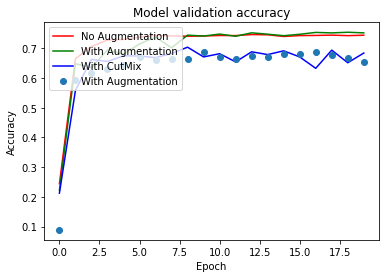

In [101]:
plt.figure(figsize=(8, 4))
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'o')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation','With Augmentation','With CutMix', 'With Mixup'], loc='lower right')
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'o')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation','With Augmentation','With CutMix+Aug', 'With Mixup+Aug'], loc='lower right')
plt.show()

#### 5. 결과 

- 기본적인 Augmentation을 적용한 데이터가 적용하지 않은 데이터보다 더 성능이 향상되었다. 
- CutMix를 적용한 데이터가 기본적인 데이터에 비해 성능이 떨어진다. 
- Mixup은 CutMix와 비슷한 성능을 보여준다. 
- 기본적인 Augmentation과 함께 CutMix나 Mixup을 적용한 데이터를 이용하면 성능이 향상되길 기대하였지만 큰 차이가 나지 않았다. 

#### 6. 고찰

- 이 프로젝트를 통해 이미지 크기를 바꾸거나 자르는 등의 방법만 알고 있었는데 최신의 Augmentation의 기법을 알 수 있는 계기가 되었다. 
- 최신의 기법이 더욱 좋은 성능을 내줄 것이라고 생각하였는데 성능이 좋지 않은 것을 확인 할 수 있었는데 기본 Augmentation은 랜덤한 이미지에 적용하는 반면에 CutMix와 Mixup은 모든 이미지를 적용하여 주어 오히려 예측 성능이 떨어지는 것이 아닐까라는 의문이 든다. 
- CutMix와 Mixup도 랜덤한 이미지만 적용을 하여 실험해 볼 필요가 있을 것 같다. 